In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [72]:
data = pd.read_csv("data/data.csv",delimiter=';')

In [73]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
row_num             988681 non-null int64
locale              988681 non-null object
day_of_week         988681 non-null object
hour_of_day         988681 non-null int64
agent_id            988681 non-null int64
entry_page          988681 non-null int64
path_id_set         983792 non-null object
traffic_type        988681 non-null int64
session_duration    988681 non-null object
hits                988681 non-null object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB
None


In [74]:
print(data.head(5))

   row_num locale day_of_week  hour_of_day  agent_id  entry_page path_id_set  \
0   988681     L6      Monday           17         1        2111     31672;0   
1   988680     L2    Thursday           22        10        2113     31965;0   
2   988679     L4    Saturday           21         2        2100     0;78464   
3   988678     L3    Saturday           19         8        2113       51462   
4   988677     L2     Tuesday            6        10        2116     31931;0   

   traffic_type session_duration hits  
0             6             7037   \N  
1             2               49   14  
2             1             1892   14  
3             6                0    1  
4             1                2    3  


In [75]:
# filling null values with zero in the 'session duration' column
data.loc[data["session_duration"]=="\\N"] = 0

In [76]:
# handling the column having the null values for 'hits'
# the rows having negative hits will help us identify as the validation dataset
# the validation data set is the one used to create the final results for submission
data.loc[data["hits"] == "\\N", 'revised_hits'] = -1
data.loc[data["hits"] != "\\N", 'revised_hits'] = data.hits

In [77]:
# dropping 'hits' column
data = data.drop(["hits"],axis=1)

In [78]:
# some columns show categorical behaviour. Confirming the same
print(pd.unique(data["locale"]))

['L6' 'L2' 'L4' 'L3' 'L1' 'L5' 0]


In [79]:
print(pd.unique(data["agent_id"]))

[ 1 10  2  8  9 11  6 13  0 14  7 12  3  4 15  5]


In [80]:
print(pd.unique(data["traffic_type"]))

[ 6  2  1  4  3 10  7  0]


In [81]:
print(pd.unique(data["hour_of_day"]))

[17 22 21 19  6  1 20  3  5 15 14 16 23  0  9 12  8  7 18 13 11 10  2  4]


In [82]:
print(pd.unique(data["day_of_week"]))

['Monday' 'Thursday' 'Saturday' 'Tuesday' 'Friday' 'Sunday' 'Wednesday' 0]


In [83]:
# casting each column to the correct data type
data.revised_hits = data.revised_hits.astype(int)
data.session_duration = data.session_duration.astype(float)
data.locale = data.locale.astype('category')
data.day_of_week = data.day_of_week.astype('category')
data.agent_id = data.agent_id.astype('category')
data.traffic_type = data.traffic_type.astype('category')
data.hour_of_day = data.hour_of_day.astype('category')

In [84]:
# rechecking the schema
data.info()

# only 'path_id_set' is of mixed type as it still contains null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
row_num             988681 non-null int64
locale              988681 non-null category
day_of_week         988681 non-null category
hour_of_day         988681 non-null category
agent_id            988681 non-null category
entry_page          988681 non-null int64
path_id_set         983792 non-null object
traffic_type        988681 non-null category
session_duration    988681 non-null float64
revised_hits        988681 non-null int64
dtypes: category(5), float64(1), int64(3), object(1)
memory usage: 42.4+ MB


In [85]:
# starting feature engineering
# here we try to find the total locations visited in each session
data["number_of_locations_visited"] = data.apply(lambda row: len(str(row.path_id_set).split(";")), axis=1)

In [86]:
# here we uniformly divide the hits for each session into each location visited
# this is done to keep one row for each path id in the 'path_id_set' column
# distribute hits for each path id
data['distributed_hits'] = data.apply(lambda row: float(row.revised_hits) / len(str(row.path_id_set).split(";")), axis=1)

In [87]:
# checking new features
data.head(5)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_duration,revised_hits,number_of_locations_visited,distributed_hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037.0,-1,2,-0.5
1,988680,L2,Thursday,22,10,2113,31965;0,2,49.0,14,2,7.0
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892.0,14,2,7.0
3,988678,L3,Saturday,19,8,2113,51462,6,0.0,1,1,1.0
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2.0,3,2,1.5


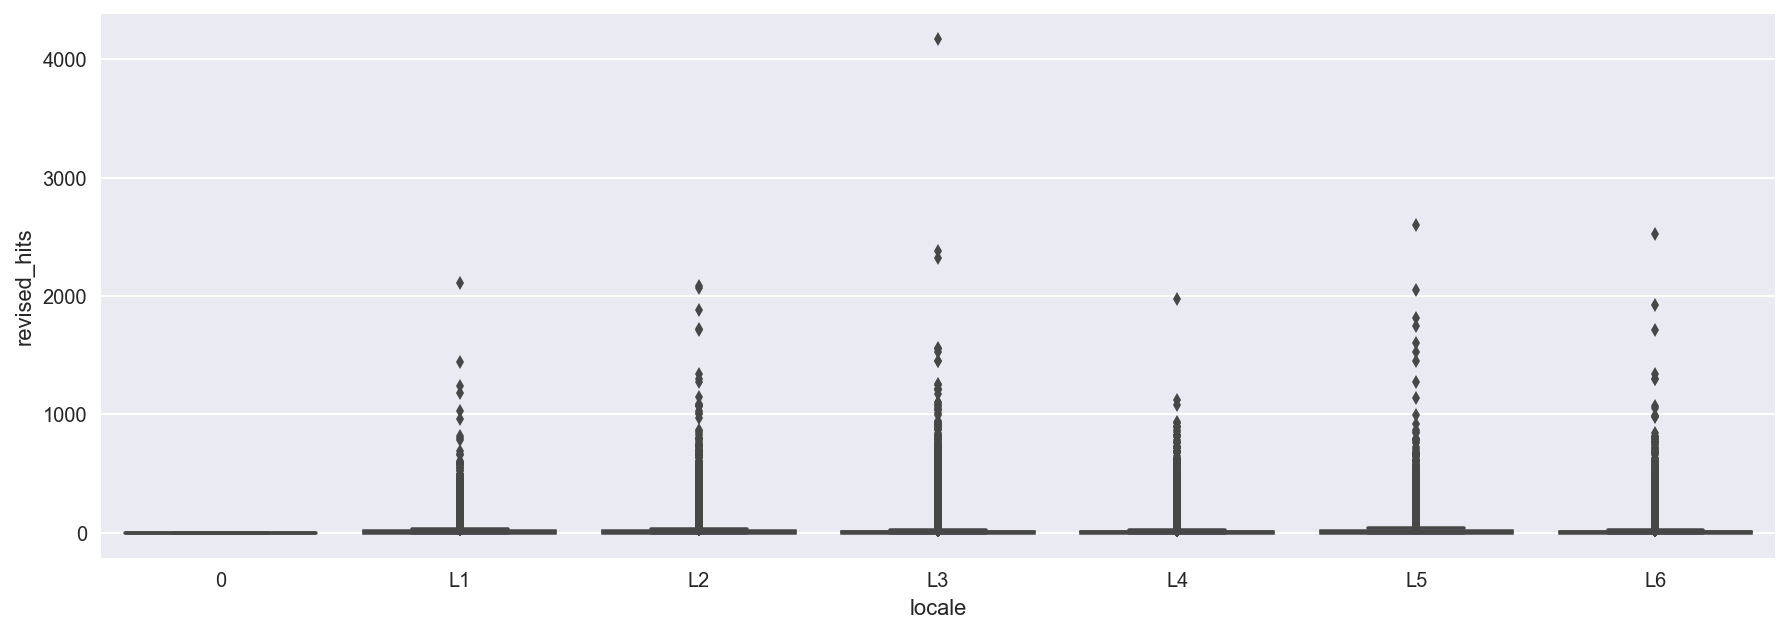

In [96]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 5)
sn.boxplot(data=data,y="revised_hits",x="locale",orient="v",ax=axes)

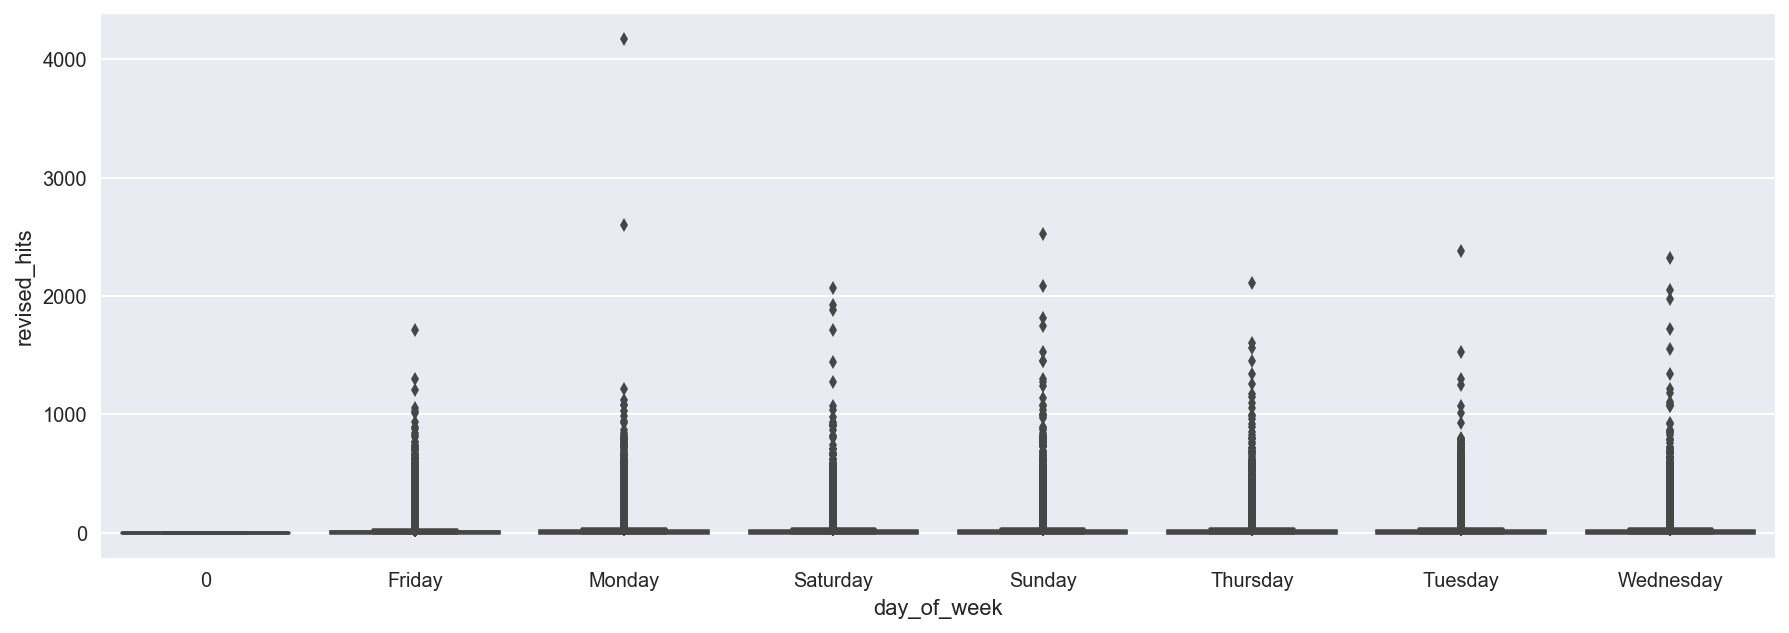

In [98]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 5)
sn.boxplot(data=data,y="revised_hits",x="day_of_week",orient="v",ax=axes)

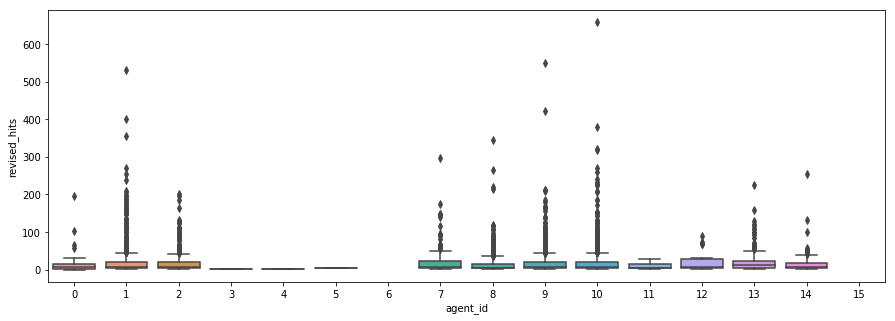

In [154]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 5)
sn.boxplot(data=data_train_test,y="revised_hits",x="agent_id",orient="v",ax=axes)

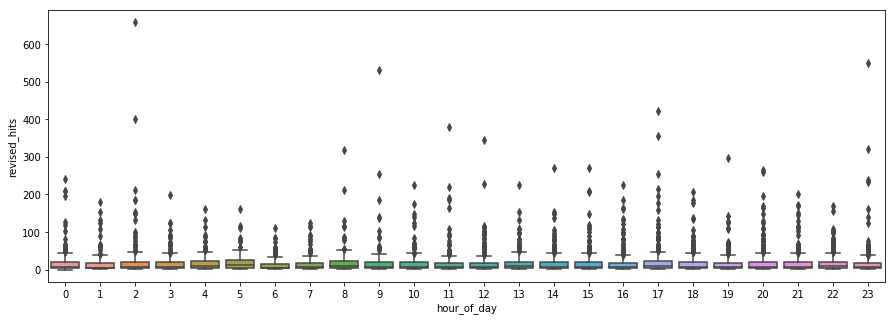

In [155]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 5)
sn.boxplot(data=data_train_test,y="revised_hits",x="hour_of_day",orient="v",ax=axes)

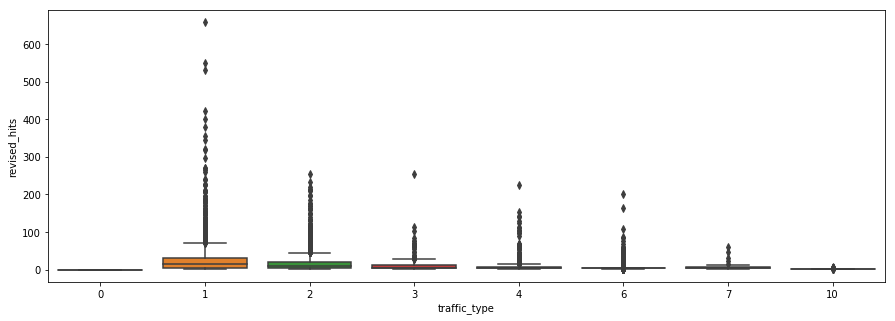

In [156]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 5)
sn.boxplot(data=data_train_test,y="revised_hits",x="traffic_type",orient="v",ax=axes)

              total_sessions   avg_hits  total_hits
traffic_type                                       
0                          8   0.000000           0
1                       1999  27.597299       55167
2                       2099  18.391615       38604
3                        349  12.060172        4209
4                        836   9.431818        7885
6                        944   5.911017        5580
7                         26   9.846154         256
10                        70   2.257143         158


Text(0,0.5,'avg_hits')

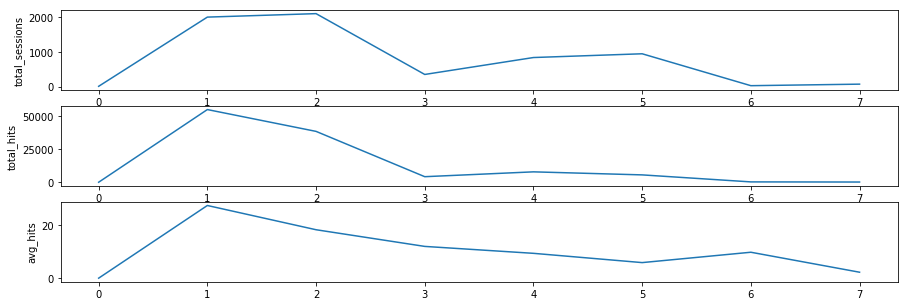

In [157]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15,5)
sessions_per_traffic = data_train_test.groupby("traffic_type")["row_num"].count()
hits_per_traffic = data_train_test.groupby("traffic_type")["revised_hits"].sum()
avg_hits_per_traffic = data_train_test.groupby("traffic_type")["revised_hits"].mean()
df = pd.DataFrame({"total_sessions":sessions_per_traffic,"avg_hits":avg_hits_per_traffic,"total_hits":hits_per_traffic})
print(df)
ax1.plot(df["total_sessions"].values)
ax1.set_ylabel("total_sessions")
ax2.plot(df["total_hits"].values)
ax2.set_ylabel("total_hits")
ax3.plot(df["avg_hits"].values)
ax3.set_ylabel("avg_hits")
plt.

        total_sessions   avg_hits  total_hits
locale                                       
0                    8   0.000000           0
L1                 283  15.982332        4523
L2                1106  19.439421       21500
L3                2188  17.298446       37849
L4                 856  16.811916       14391
L5                 720  21.490278       15473
L6                1170  15.489744       18123


Text(0,0.5,'avg_hits')

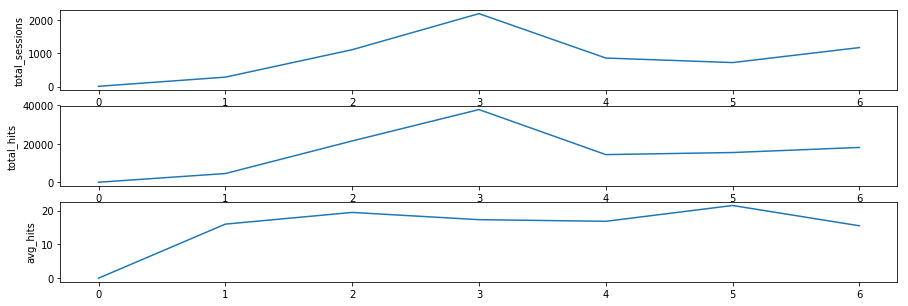

In [158]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15,5)
sessions_per_traffic = data_train_test.groupby("locale")["row_num"].count()
hits_per_traffic = data_train_test.groupby("locale")["revised_hits"].sum()
avg_hits_per_traffic = data_train_test.groupby("locale")["revised_hits"].mean()
df = pd.DataFrame({"total_sessions":sessions_per_traffic,"avg_hits":avg_hits_per_traffic,"total_hits":hits_per_traffic})
print(df)
ax1.plot(df["total_sessions"].values)
ax1.set_ylabel("total_sessions")
ax2.plot(df["total_hits"].values)
ax2.set_ylabel("total_hits")
ax3.plot(df["avg_hits"].values)
ax3.set_ylabel("avg_hits")

             total_sessions   avg_hits  total_hits
hour_of_day                                       
0                       280  16.735714        4686
1                       225  15.084444        3394
2                       214  24.014019        5139
3                       191  16.869110        3222
4                       131  18.648855        2443
5                       117  19.564103        2289
6                       154  13.006494        2003
7                       163  16.153374        2633
8                       164  19.951220        3272
9                       181  20.397790        3692
10                      228  17.706140        4037
11                      225  17.995556        4049
12                      273  17.666667        4823
13                      307  16.990228        5216
14                      306  16.284314        4983
15                      342  16.809942        5749
16                      333  17.048048        5677
17                      357  21

Text(0,0.5,'avg_hits')

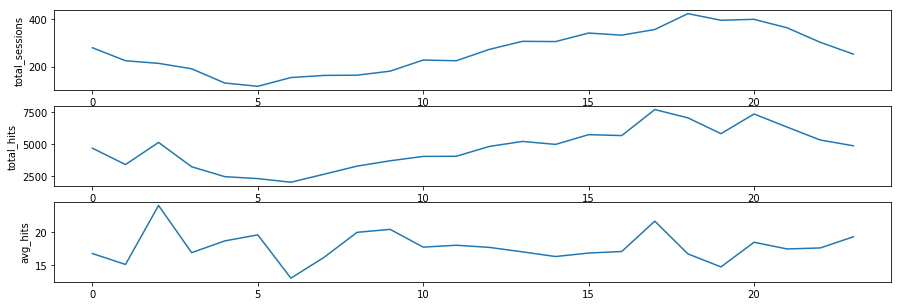

In [159]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15,5)
sessions_per_traffic = data_train_test.groupby("hour_of_day")["row_num"].count()
hits_per_traffic = data_train_test.groupby("hour_of_day")["revised_hits"].sum()
avg_hits_per_traffic = data_train_test.groupby("hour_of_day")["revised_hits"].mean()
df = pd.DataFrame({"total_sessions":sessions_per_traffic,"avg_hits":avg_hits_per_traffic,"total_hits":hits_per_traffic})
print(df)
ax1.plot(df["total_sessions"].values)
ax1.set_ylabel("total_sessions")
ax2.plot(df["total_hits"].values)
ax2.set_ylabel("total_hits")
ax3.plot(df["avg_hits"].values)
ax3.set_ylabel("avg_hits")

             total_sessions   avg_hits  total_hits
day_of_week                                       
0                         8   0.000000           0
Friday                  857  17.673279       15146
Monday                 1028  17.280156       17764
Saturday                774  17.852713       13818
Sunday                  932  18.478541       17222
Thursday                855  18.639766       15937
Tuesday                1014  17.172584       17413
Wednesday               863  16.870220       14559


Text(0,0.5,'avg_hits')

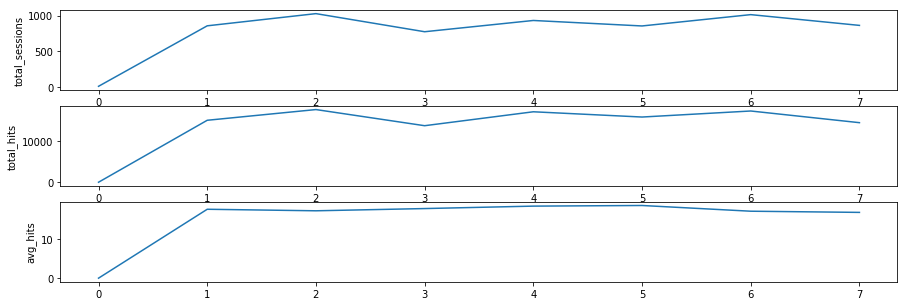

In [160]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15,5)
sessions_per_traffic = data_train_test.groupby("day_of_week")["row_num"].count()
hits_per_traffic = data_train_test.groupby("day_of_week")["revised_hits"].sum()
avg_hits_per_traffic = data_train_test.groupby("day_of_week")["revised_hits"].mean()
df = pd.DataFrame({"total_sessions":sessions_per_traffic,"avg_hits":avg_hits_per_traffic,"total_hits":hits_per_traffic})
print(df)
ax1.plot(df["total_sessions"].values)
ax1.set_ylabel("total_sessions")
ax2.plot(df["total_hits"].values)
ax2.set_ylabel("total_hits")
ax3.plot(df["avg_hits"].values)
ax3.set_ylabel("avg_hits")

In [161]:
sessions_per_entry_page = data_train_test.groupby("entry_page")["row_num"].count()
hits_per_entry_page = data_train_test.groupby("entry_page")["revised_hits"].sum()
df_ep = pd.DataFrame({"total_sessions":sessions_per_entry_page,"total_hits":hits_per_entry_page})
print(df_ep.nlargest(10,["total_sessions"]))
print(df_ep.nlargest(10,["total_hits"]))

            total_sessions  total_hits
entry_page                            
2113                  2111       30043
2116                  1303       17145
2100                  1144       32745
2111                   496        7954
2114                   456        5293
2700                   398       13273
8001                   109         550
2115                   108        1721
2226                    55         736
2227                    23         109
            total_sessions  total_hits
entry_page                            
2100                  1144       32745
2113                  2111       30043
2116                  1303       17145
2700                   398       13273
2111                   496        7954
2114                   456        5293
2115                   108        1721
2226                    55         736
8001                   109         550
2142                    19         529


In [162]:
data_train_test = data_train_test.join(df_ep,on="entry_page")

In [164]:
data_train_test.head(5)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_duration,revised_hits,number_of_pages_visited,total_sessions,total_hits,distributed_hits
1,988680,L2,Thursday,22,10,2113,31965;0,2,49.0,14,2,2111,30043,7.0
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892.0,14,2,1144,32745,7.0
3,988678,L3,Saturday,19,8,2113,51462,6,0.0,1,1,2111,30043,1.0
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2.0,3,2,1303,17145,1.5
5,988676,L3,Monday,1,8,2100,0,1,0.0,2,1,1144,32745,2.0


In [165]:
s1 = data_train_test["path_id_set"].apply(lambda x: str(x).split(";")) #convert to string if not already
s2 = s1.apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
s2.name = "path_id"

In [166]:
# explode path id for each row into multiple rows
data_train_test = data_train_test.drop("path_id_set",axis=1).join(s2)

In [ ]:
data_train_test.loc[data_train_test["path_id"]=="nan"] = 0

In [167]:
data_train_test.head(5)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,traffic_type,session_duration,revised_hits,number_of_pages_visited,total_sessions,total_hits,distributed_hits,path_id
1,988680,L2,Thursday,22,10,2113,2,49.0,14,2,2111,30043,7.0,31965
1,988680,L2,Thursday,22,10,2113,2,49.0,14,2,2111,30043,7.0,0
2,988679,L4,Saturday,21,2,2100,1,1892.0,14,2,1144,32745,7.0,0
2,988679,L4,Saturday,21,2,2100,1,1892.0,14,2,1144,32745,7.0,78464
3,988678,L3,Saturday,19,8,2113,6,0.0,1,1,2111,30043,1.0,51462


In [168]:
# converting categorical columns to one-hot-encoded form into multiple columns
locale_dummy_df = pd.get_dummies(data_train_test["locale"])
day_of_week_dummy_df = pd.get_dummies(data_train_test["day_of_week"])
agent_id_dummy_df = pd.get_dummies(data_train_test["agent_id"])
traffic_type_dummy_df = pd.get_dummies(data_train_test["traffic_type"])
hour_of_day_dummy_df = pd.get_dummies(data_train_test["hour_of_day"])

In [169]:
data_train_test = data_train_test.drop(["locale","day_of_week","agent_id","traffic_type","revised_hits","hour_of_day"],axis=1)

In [170]:
data_train_test.head(5)

,row_num,entry_page,session_duration,number_of_pages_visited,total_sessions,total_hits,distributed_hits,path_id
1,988680,2113,49.0,2,2111,30043,7.0,31965
1,988680,2113,49.0,2,2111,30043,7.0,0
2,988679,2100,1892.0,2,1144,32745,7.0,0
2,988679,2100,1892.0,2,1144,32745,7.0,78464
3,988678,2113,0.0,1,2111,30043,1.0,51462


In [172]:
data_train_test.path_id = data_train_test.path_id.astype(int)

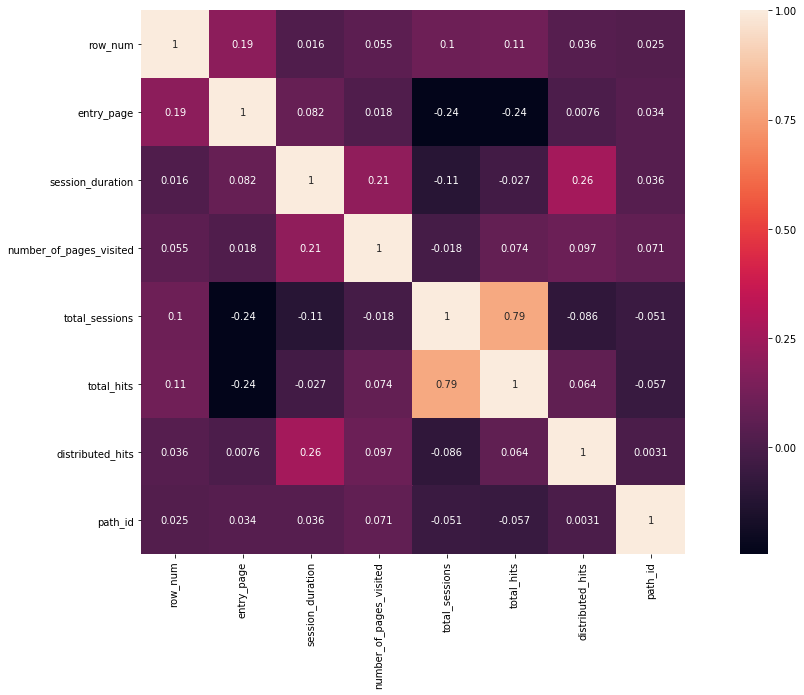

In [173]:
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(data_train_test.corr(),vmax=1, square=True,annot=True)
plt.show()